In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))

# To get the example images that below worked on please first run the download_assets.py file

#### High Dynamic Range (HDR) Imaging

!["HDR Image Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_high-dynamic-range-hdr.jpg)

#### Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

#### Step 1: Capture Multiple Exposures

!["HDR Image Sequence"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_hdr-image-sequence.jpg)

In [56]:
file_names = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]


def readImagesAndTimes():
    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    images = []
    for name in file_names:
        img = cv2.imread(f"{DATA_RAW_PATH}/{name}", cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        images.append(img)

    return images, times

#### Step 2: Align Images

![Aligned vs. Unaligned](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_aligned-unaligned-hdr-comparison.jpg)

In [57]:
images, times = readImagesAndTimes()

alignMTB = cv2.createAlignMTB()
alignMTB.process(dst=images, src=images)

1. cv2.**createAlignMTB()**
   - Creates an object that uses Median Threshold Bitmap alignment.
2. **alignMTB.process**(images, images)
   - Takes a list of input images (different exposures)
   - Aligns them using MTB method
   - Writes aligned images in-place (to the same list)

##### MTB (Median Threshold Bitmap)

It doesn’t align by comparing pixel brightness directly (which changes with exposure).

Instead, it uses a clever trick:

- It creates bitmaps:
  - For each image, compute the median pixel intensity
  - Then mark:
    - 1 if pixel > median
    - 0 if pixel < median

This forms a binary image called the threshold bitmap.

These bitmaps are independent of exposure (because they only care about relative brightness), so they can be aligned robustly using simple shift/match techniques.

**Now images[0], images[1], images[2] etc. are all aligned -> ready to merge into HDR!**

#### Step 3: Estimate Camera Response Function

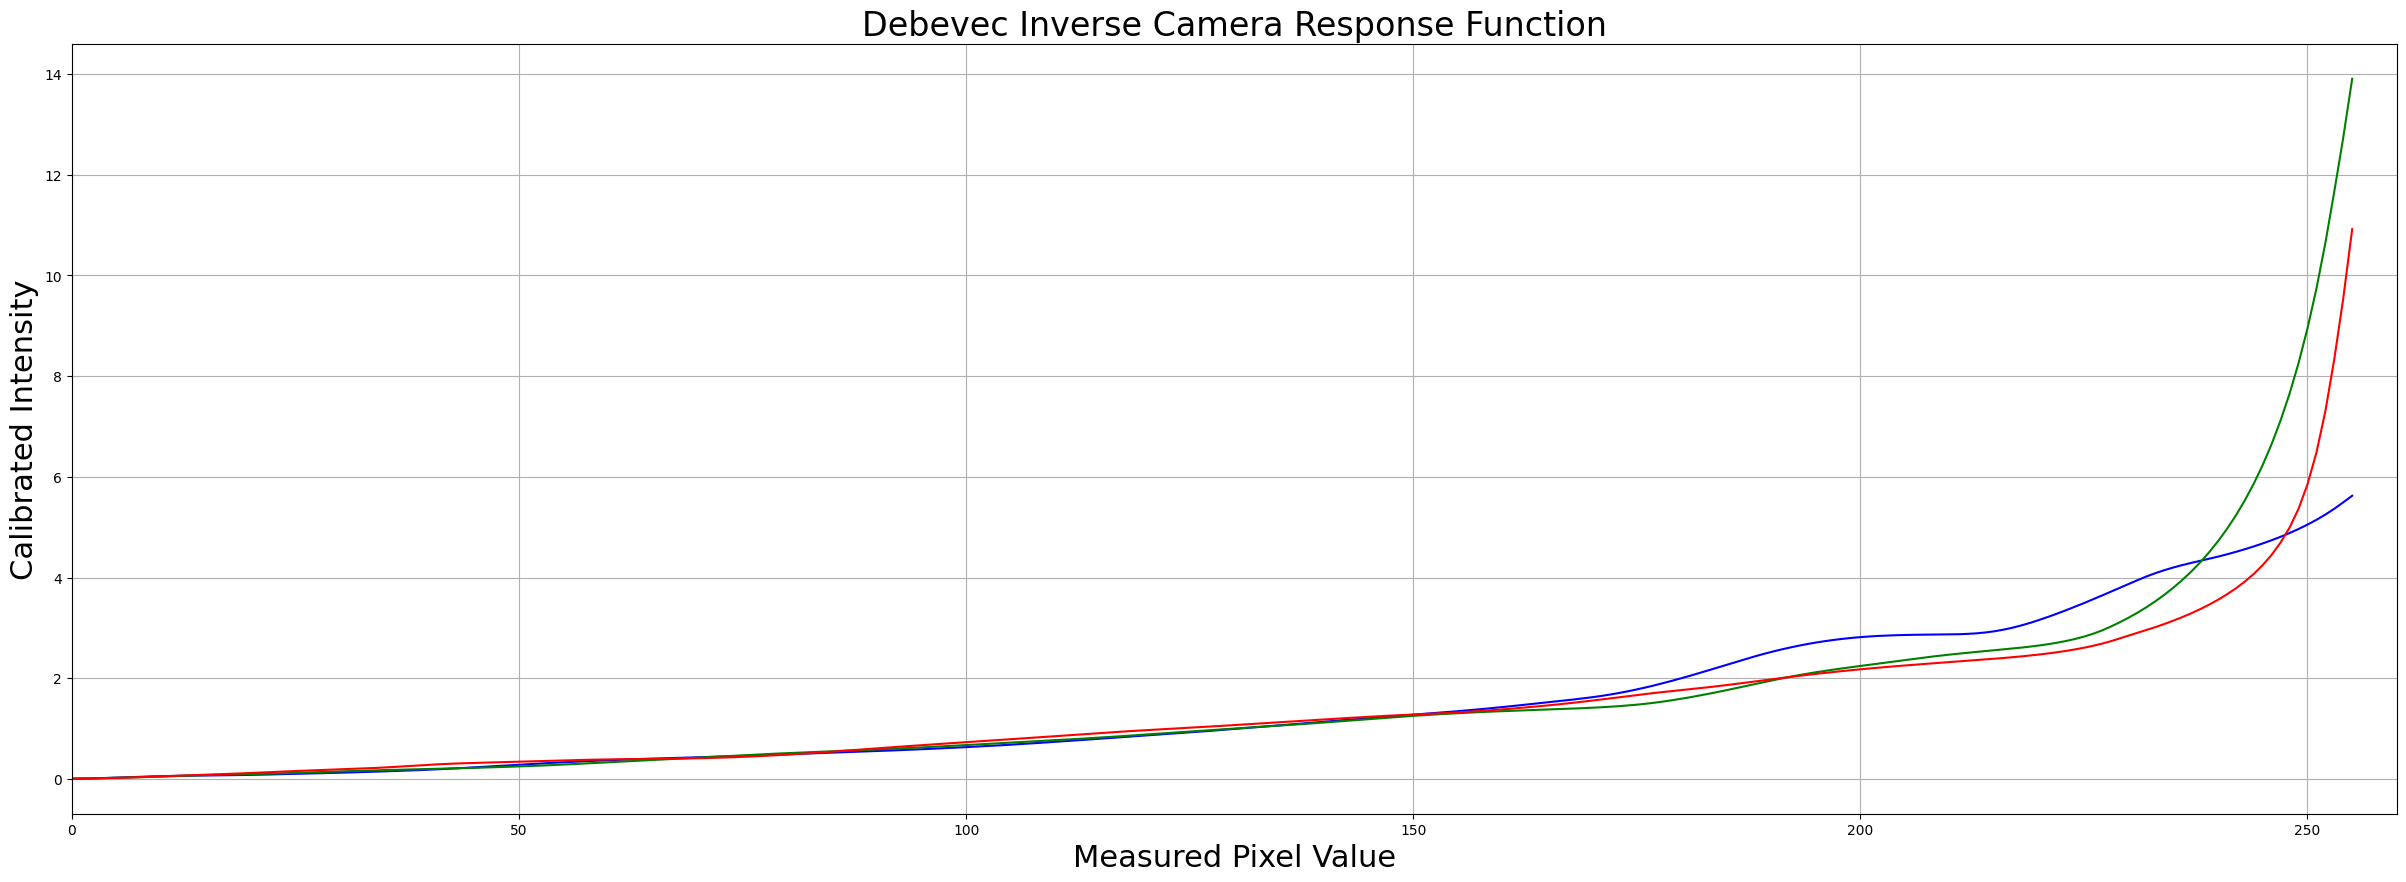

In [58]:
# Find Camera Response Function (CRF)
calibrate_debevec = cv2.createCalibrateDebevec()
responce_debevec = calibrate_debevec.process(images, times)

# Plot CRF
x = np.arange(0, 256, dtype=np.uint8)  # [0, 1, 2, 3, ... 255]
# squeeze: removal of single-dimensional elements from the shape of a NumPy array
y = np.squeeze(responce_debevec)

ax = plt.figure(figsize=[30, 10])
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")

#### Step 4: Merge Exposure into an HDR Image

In [59]:
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(images, times, responce_debevec)

#### Step 5: Tonemapping

Many Tonemapping algorithms are available in OpenCV. We chose Drago as it has more controls.

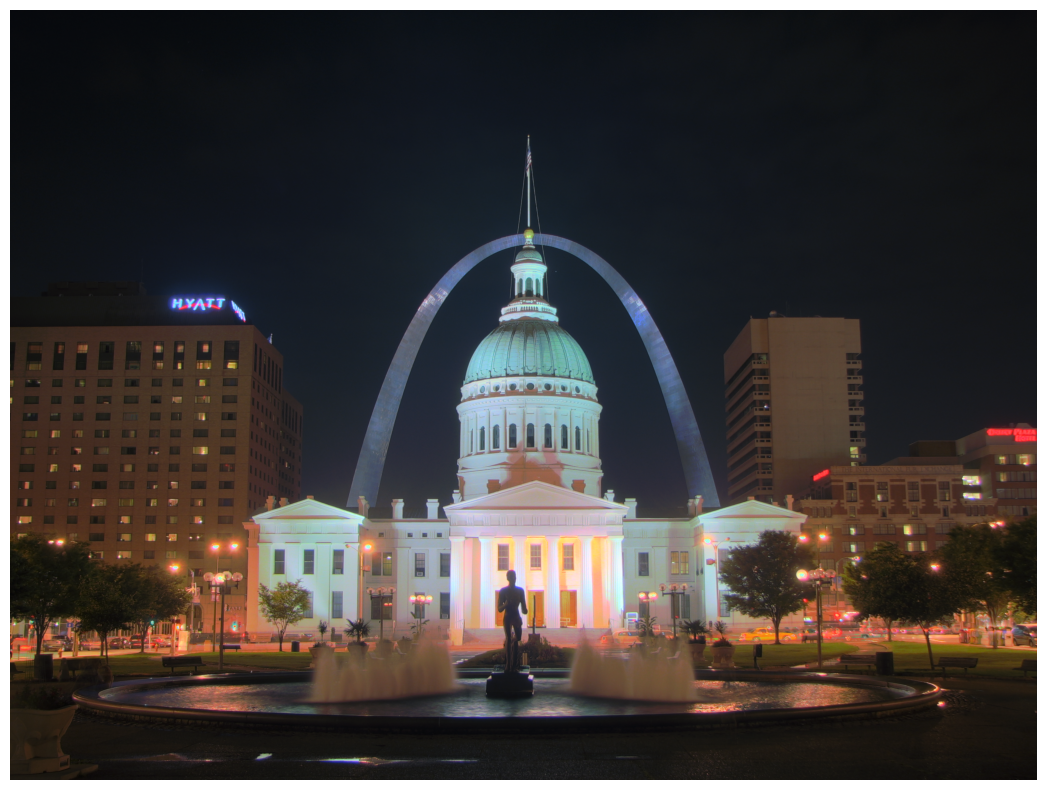

In [60]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemap_drago = cv2.createTonemapDrago(1.0, 0.7)
ldr_drago = tonemap_drago.process(hdr_debevec)
ldr_drago = 3 * ldr_drago

cv2.imwrite(f"{DATA_OUTPUT_PATH}/ldr-Drago.jpg", 255*ldr_drago)


def plot_image(img_MatLike):
    plt.figure(figsize=(20, 10))
    plt.imshow(np.clip(img_MatLike, 0, 1))
    plt.axis("off")


plot_image(ldr_drago)

Tonemaping using Reinhard's method ... 


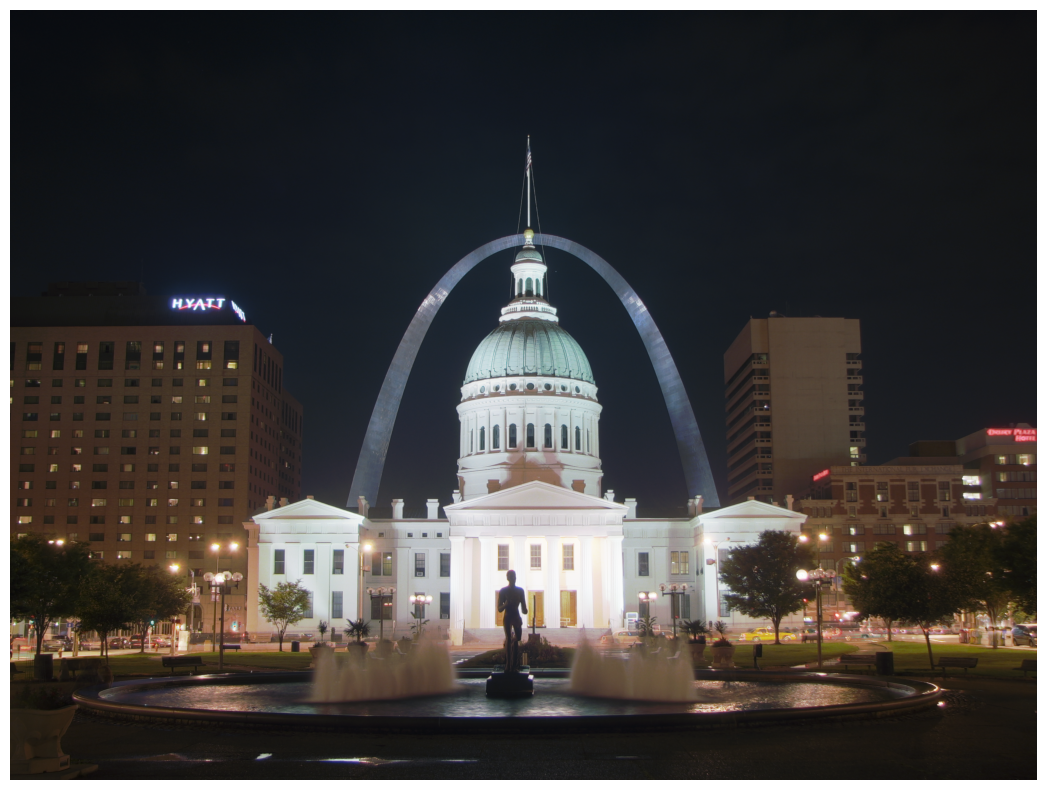

In [61]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemap_reinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldr_reingard = tonemap_reinhard.process(hdr_debevec)

cv2.imwrite(f"{DATA_OUTPUT_PATH}/ldr-Reinhard.jpg", ldr_reingard * 255)

plot_image(ldr_reingard)

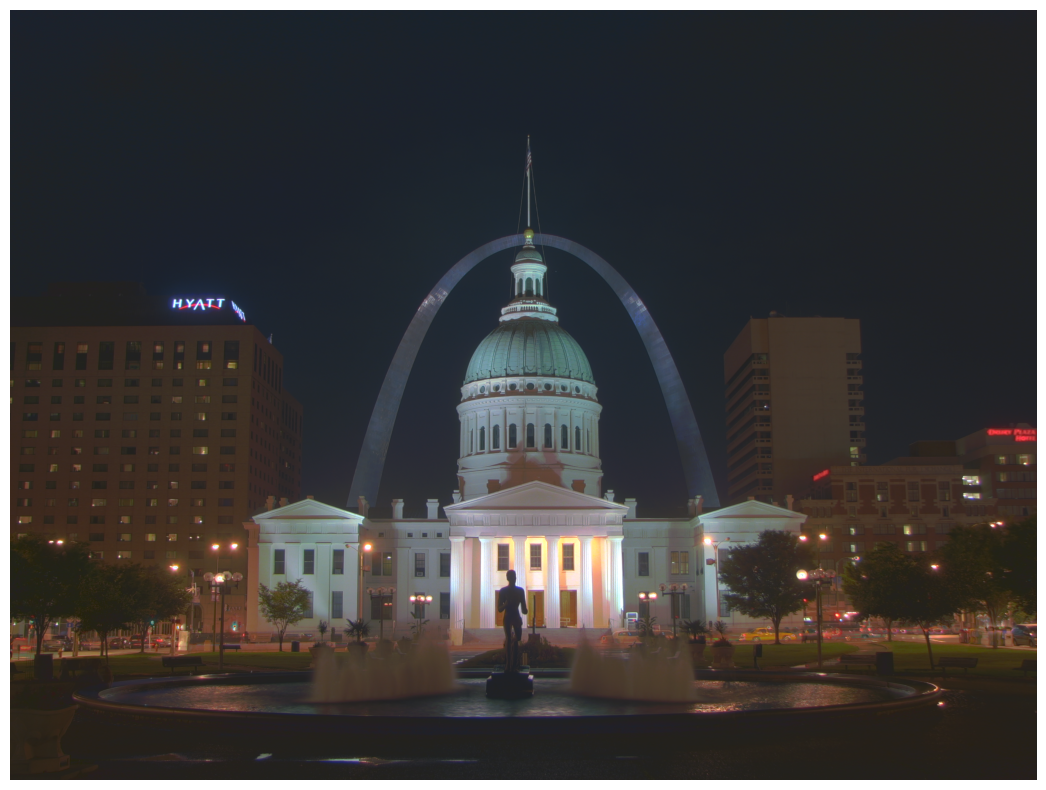

In [62]:
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldr_mantiuk = tonemapMantiuk.process(hdr_debevec)
ldr_mantiuk = 3 * ldr_mantiuk

cv2.imwrite(f"{DATA_OUTPUT_PATH}/ldr-Mantiuk.jpg", ldr_mantiuk * 255)

plot_image(ldr_mantiuk)